# Installation des packages

# Préparation des données

In [ ]:
from scripts import data_collector as dc
from scripts import data_cleaner as dcl
from scripts import data_analysis as da
from scripts import data_visualization as dv
from scripts import regression as rg
import pandas as pd
import numpy as np

landlocked_url = "https://en.wikipedia.org/wiki/List_of_countries_by_length_of_coastline"
codesISO_url = "https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes"

# Codes ISO-2 et ISO-3 relatifs aux pays

In [2]:
try:
    codesISO_data = dc.get_ISOcodes(codesISO_url)
    codesISO_data = dcl.clean_ISOData(codesISO_data)
except Exception as e:
    print(f"An error occurred while fetching or cleaning ISO codes data: {e}")
    codesISO_data = pd.read_csv("data/ISO_data.csv")
    codesISO_data.drop(columns=['Unnamed: 0'], inplace=True)
    
codesISO_data

,Pays,ISO-2,ISO-3
0,Afghanistan,AF,AFG
1,Albania,AL,ALB
2,Algeria,DZ,DZA
3,Andorra,AD,AND
4,Angola,AO,AGO
...,...,...,...
188,Venezuela (Bolivarian Republic of),VE,VEN
189,Viet Nam[ak],VN,VNM
190,Yemen,YE,YEM
191,Zambia,ZM,ZMB


# PIB Réel

L'API permet de récupérer des données sur les pays via leurs codes ISO avec 2 lettres
Exemple : "FR" pour la France, "DE" pour l'Allemagne, "GB" pour le Royaume-Uni, etc.

In [3]:
wb = dc.WorldBankData()

# Récupérer le PIB réel pour tous les pays du monde entre 1900 et 2024
liste_pays = codesISO_data["ISO-3"].tolist()
PIB_Reel_data = wb.get_indicator("PIB", liste_pays, start=1990, end=2024)
PIB_Reel_data

,country,date,PIB
0,Afghanistan,2024,NaN
1,Afghanistan,2023,1.567265e+10
2,Afghanistan,2022,1.532523e+10
3,Afghanistan,2021,1.634520e+10
4,Afghanistan,2020,2.062196e+10
...,...,...,...
6750,Zimbabwe,1994,1.776635e+10
6751,Zimbabwe,1993,1.626430e+10
6752,Zimbabwe,1992,1.609508e+10
6753,Zimbabwe,1991,1.768993e+10


Il y a des problèmes avec les correspondances de noms entre les codes ISO et les noms des pays dans le dataframe PIB_reel_data
# Faire correspondre les noms des pays à la liste des ISO

In [4]:
PIB_countries = set(PIB_Reel_data["country"].unique())
ISO_countries = set(codesISO_data["Pays"].unique())

matching_dictionnary = {}

# Récupérer les pays avec un seul mot dans leur nom
single_word_countries = set(PIB_Reel_data[PIB_Reel_data['country'].str.split().str.len() == 1]['country'].tolist())
ISO_complicated_word_countries = ISO_countries 
potential_matching_complicated_word_countries = PIB_countries 

# Premier algorithme de matching basé sur les pays où les noms n'ont pas des caractères bizarres mais juste plusieurs mots
solved_ISO_complicated_word_countries = set()
solved_potential_matching_word_countries = set()

for iso_country in ISO_complicated_word_countries:
    for pib_country in potential_matching_complicated_word_countries:
        if iso_country in pib_country or pib_country in iso_country:
            matching_dictionnary[pib_country] = iso_country
            solved_ISO_complicated_word_countries.add(iso_country)
            solved_potential_matching_word_countries.add(pib_country)
            

# Afficher les pays non résolus après le premier algorithme
unresolved_ISO_countries = ISO_complicated_word_countries - solved_ISO_complicated_word_countries
unresolved_potential_matching_countries = potential_matching_complicated_word_countries - solved_potential_matching_word_countries

# Résoudre les derniers problèmes

for pib_country in unresolved_potential_matching_countries:
    for iso_country in unresolved_ISO_countries:
        # Je n'ai pas besoin des caractères après la virgule pour les pays problématiques.
        pib_country = pib_country.split(',')[0]
        
        if pib_country[:5] == iso_country[:5]:
            matching_dictionnary[pib_country] = iso_country
            break
        
# Résoudre les problèmes d'autres pays déviants manuellement
          
matching_dictionnary['Congo, Dem. Rep.'] = 'Congo (the Democratic Republic of the)'
matching_dictionnary['Congo, Rep.'] = 'Congo (the)[k]'
matching_dictionnary['Turkiye'] = 'Türkiye[ag]'
matching_dictionnary['Korea, Rep.'] = 'Korea (the Republic of)[u]'
matching_dictionnary['Korea, Dem. People\'s Rep.'] = 'Korea (the Democratic People\'s Republic of)[t]'
matching_dictionnary['Venezuela, RB'] = 'Venezuela (Bolivarian Republic of)'

In [5]:
# Matcher maintenant les pays aux ISO

ISO_matching_dictionnary = {}
for i in range(len(codesISO_data)):
    line = codesISO_data.iloc[i]
    ISO_matching_dictionnary[line["Pays"]] = line["ISO-3"]
    
ISO_matching_dictionnary

for key in matching_dictionnary.keys():
    matching_dictionnary[key] = ISO_matching_dictionnary[matching_dictionnary[key]]
    
matching_dictionnary

{'Panama': 'PAN',
 'San Marino': 'SMR',
 'Belarus': 'BLR',
 'Czechia': 'CZE',
 'North Macedonia': 'MKD',
 'Cabo Verde': 'CPV',
 'Barbados': 'BRB',
 'Afghanistan': 'AFG',
 'Saudi Arabia': 'SAU',
 'Syrian Arab Republic': 'SYR',
 'Denmark': 'DNK',
 'Paraguay': 'PRY',
 'Bhutan': 'BTN',
 'Norway': 'NOR',
 'Greece': 'GRC',
 'Tonga': 'TON',
 'Eritrea': 'ERI',
 'Lithuania': 'LTU',
 'Senegal': 'SEN',
 'Mauritius': 'MUS',
 'India': 'IND',
 'Sao Tome and Principe': 'STP',
 'Vanuatu': 'VUT',
 'Cuba': 'CUB',
 'Costa Rica': 'CRI',
 'Mozambique': 'MOZ',
 'Uzbekistan': 'UZB',
 'Azerbaijan': 'AZE',
 'Comoros': 'COM',
 'Monaco': 'MCO',
 'Philippines': 'PHL',
 'Qatar': 'QAT',
 'Solomon Islands': 'SLB',
 'Myanmar': 'MMR',
 'Ireland': 'IRL',
 'United Kingdom': 'GBR',
 'Botswana': 'BWA',
 'Brunei Darussalam': 'BRN',
 'Hungary': 'HUN',
 'Chile': 'CHL',
 'Jordan': 'JOR',
 'Sudan': 'SSD',
 'Marshall Islands': 'MHL',
 'Chad': 'TCD',
 'Iceland': 'ISL',
 'South Africa': 'ZAF',
 'Timor-Leste': 'TLS',
 'Togo': 'TGO

In [6]:
PIB_Reel_data["country"] = PIB_Reel_data['country'].apply(lambda x: matching_dictionnary[x] if x in matching_dictionnary.keys() else x)
PIB_Reel_data


,country,date,PIB
0,AFG,2024,NaN
1,AFG,2023,1.567265e+10
2,AFG,2022,1.532523e+10
3,AFG,2021,1.634520e+10
4,AFG,2020,2.062196e+10
...,...,...,...
6750,ZWE,1994,1.776635e+10
6751,ZWE,1993,1.626430e+10
6752,ZWE,1992,1.609508e+10
6753,ZWE,1991,1.768993e+10


# Valeurs manquantes

In [7]:
PIB_Reel_data
da.check_missing_values(PIB_Reel_data,"PIB")

Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 178 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 2.64% de valeurs manquantes dans la base de données.


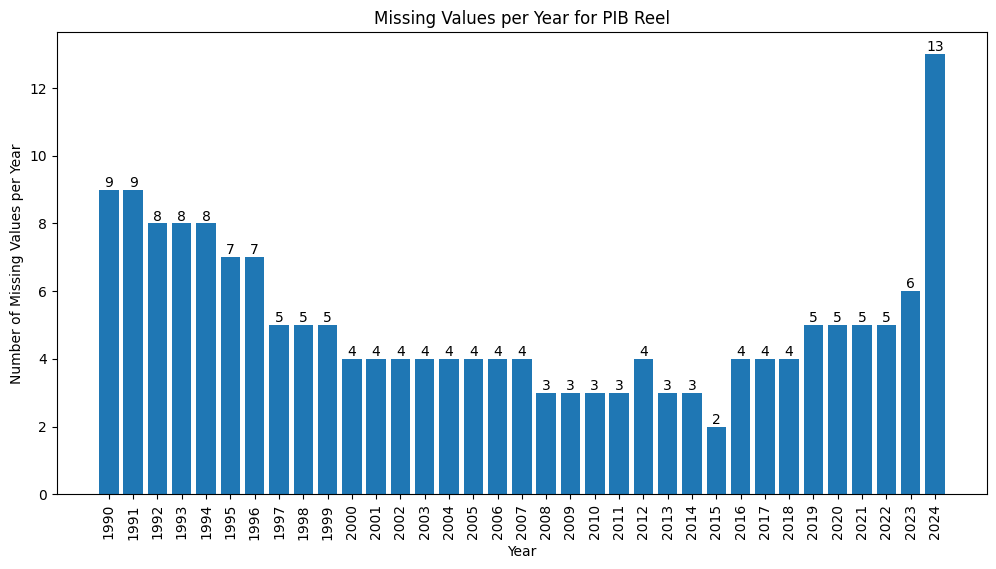

In [8]:
# Là on va checker d'où viennent les valeurs manquantes

# On va d'abord faire une analyse par date pour voir si c'est ça qui cause le problème

dv.plot_missing_values_per_year(PIB_Reel_data,"PIB")

In [9]:
# C'est bizarre qu'en 2024 il y ait plus de valeurs manquantes en 2024. Vérifions les pays dont les valeurs sont manquantes en 2024
NaN2024 = PIB_Reel_data[PIB_Reel_data["date"]==2024]["PIB"].isna()
NaN2024_countries = PIB_Reel_data[PIB_Reel_data["date"]==2024][NaN2024]
NaN2024_countries

# faire un commentaire
# Ce qu'on peut probablement faire c'est de l'imputation de données manquantes en utilisant la moyenne des valeurs des années précédentes pour chaque pays.
# Mais cela ne peut se faire que si on est dans des années qui sont intérieures c'est-à dire à partir de la première année omù il n'y a pas de valeur manquante

,country,date,PIB
0,AFG,2024,NaN
910,BTN,2024,NaN
1820,ERI,2024,NaN
3360,LBN,2024,NaN
3500,LIE,2024,NaN
4830,PLW,2024,NaN
4935,PRK,2024,NaN
5425,SMR,2024,NaN
5530,SSD,2024,NaN
5810,SYR,2024,NaN


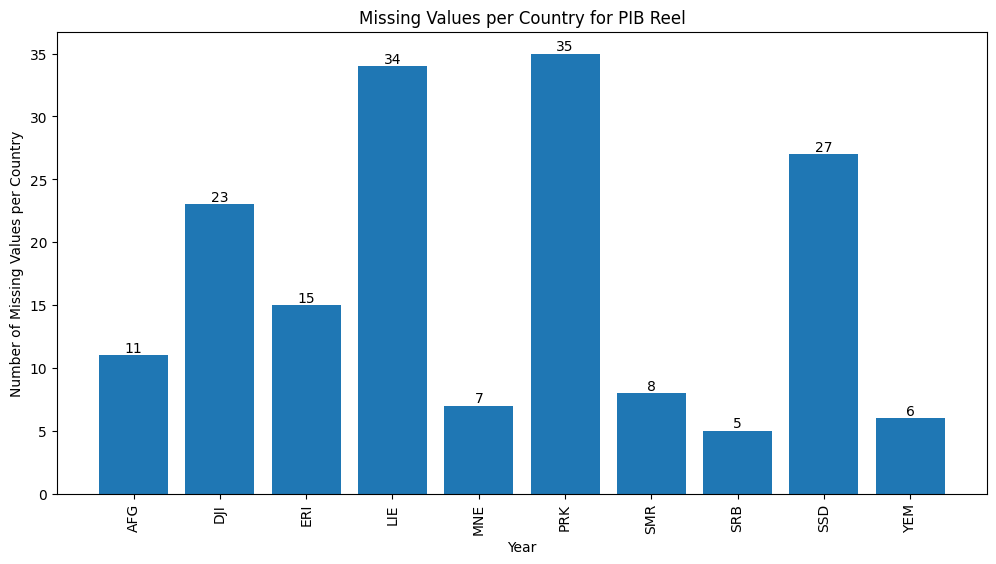

In [10]:
# Missing data per countries
# On va mettre un treshold à 5 valeurs pour tolérer 10% de données manquantes sinon on vire le pays.
countries_toRemove = dv.plot_missing_values_per_country(PIB_Reel_data,"PIB",treshold=0.1)

indexes_toRemove = []
for country in countries_toRemove:
    country_indexes = PIB_Reel_data[PIB_Reel_data["country"]==country].index.tolist()
    indexes_toRemove.extend(country_indexes)

In [11]:
PIB_Reel_data
da.check_missing_values(PIB_Reel_data,"PIB")

PIB_Reel_data_cleaned = PIB_Reel_data.drop(indexes_toRemove,axis='index')
PIB_Reel_data_cleaned.reset_index(drop=True,inplace=True)
da.check_missing_values(PIB_Reel_data_cleaned,"PIB")

Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 178 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 2.64% de valeurs manquantes dans la base de données.
Le dataframe contient des données temporelles relatives à 179 pays de 1990 à 2024.
Il y a 7 valeurs manquantes sur un total de 6370 dans la base de données. Soit un ratio de 0.11% de valeurs manquantes dans la base de données.


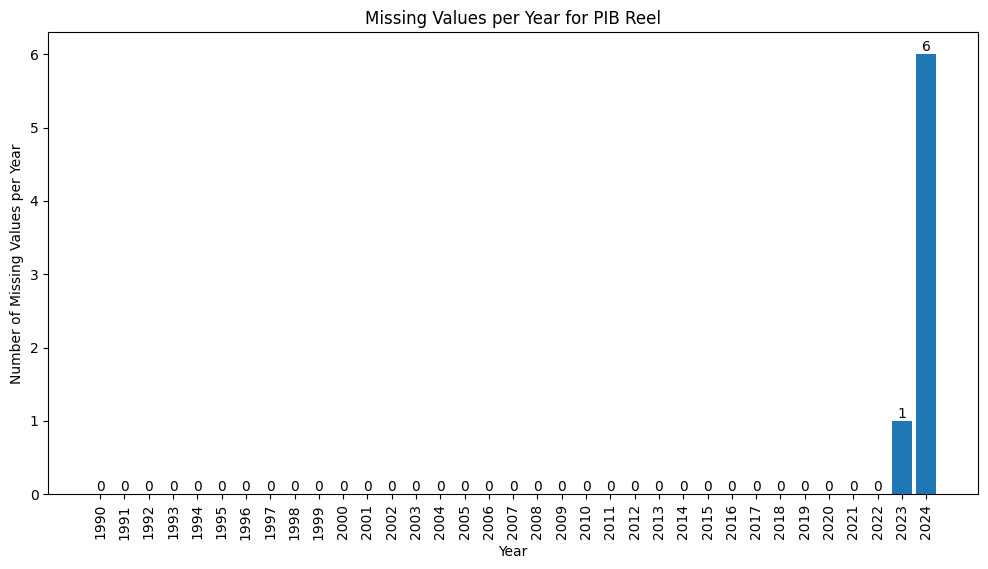

In [12]:
# On va voir où se situent les dernières valeurs manquantes
dv.plot_missing_values_per_year(PIB_Reel_data_cleaned,"PIB")

In [13]:
# La majeure partie des valeurs manquantes sont en 2024. On peut les imputer avec la moyenne des années précédentes.
PIB_Reel_data_final = da.impute_missing_values(PIB_Reel_data_cleaned,"PIB",method="mean")
da.check_missing_values(PIB_Reel_data_final,"PIB")
PIB_Reel_data_final

Le dataframe contient des données temporelles relatives à 179 pays de 1990 à 2024.
Il y a 0 valeurs manquantes sur un total de 6370 dans la base de données. Soit un ratio de 0.00% de valeurs manquantes dans la base de données.


,country,date,PIB
0,AGO,2024,1.078033e+11
1,AGO,2023,1.032363e+11
2,AGO,2022,1.019483e+11
3,AGO,2021,9.782408e+10
4,AGO,2020,9.580944e+10
...,...,...,...
6365,ZWE,1994,1.776635e+10
6366,ZWE,1993,1.626430e+10
6367,ZWE,1992,1.609508e+10
6368,ZWE,1991,1.768993e+10


## Description du PIB

## Evolution du PIB mondial

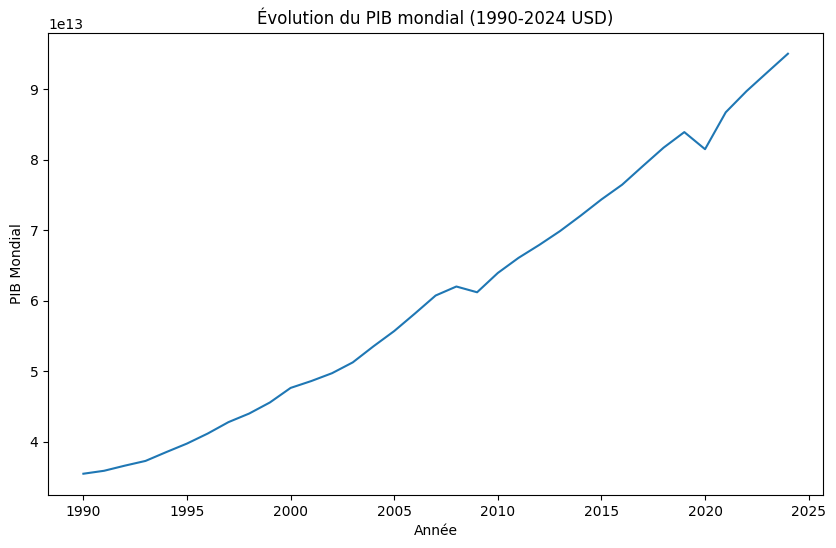

In [14]:
## Description du PIB
import matplotlib.pyplot as plt
dv.plot_world_PIB(PIB_Reel_data_final)

# Faire un commentaire

# Analyse des PIB de pays par quartiles 

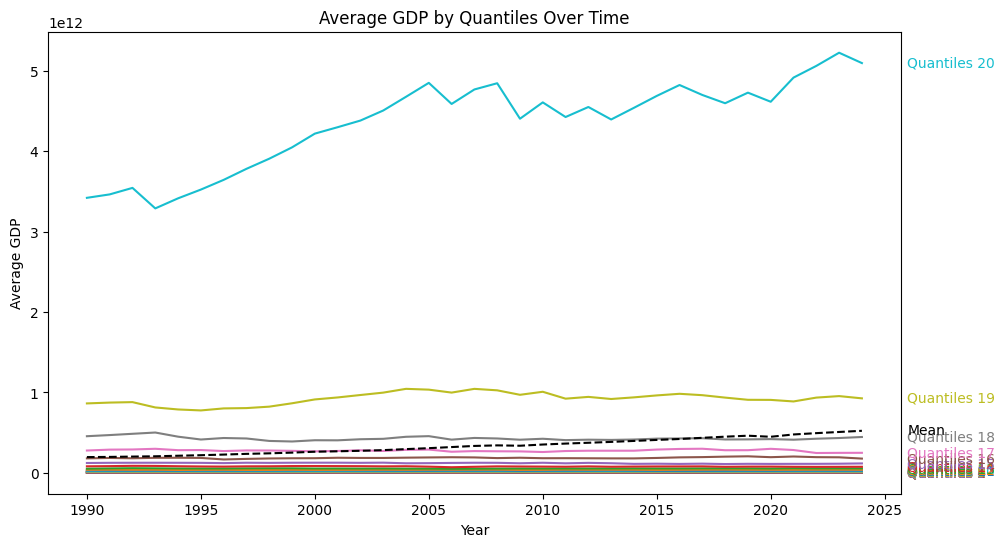

In [15]:
dv.plot_PIB_quantile(PIB_Reel_data_final)


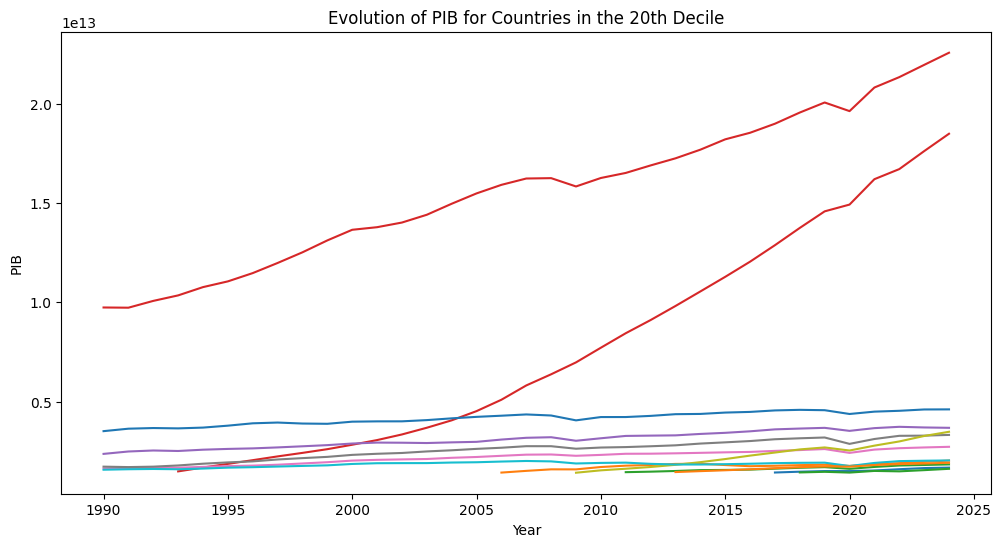

Countries in the 20th-decile: ['AUS' 'BRA' 'CAN' 'CHN' 'DEU' 'ESP' 'FRA' 'GBR' 'IND' 'ITA' 'JPN' 'KOR'
 'RUS' 'USA']


In [16]:
dv.plot_PIB_top_quantile_countries(PIB_Reel_data_final)

Faire un commentaire sur le fait que ce soient les pays les plus développés qui apparaissent dans ce graphique

# Ajout de la variable symbolisant la taille du pays dans l'économie mondiale

In [17]:
dump = PIB_Reel_data_final.groupby(['country','date']).sum().apply(lambda x: 100*x/PIB_Reel_data_final.groupby("date")["PIB"].sum()).reset_index() # Associer à chaque pays son poids dans l'économie mondiale par année
dump.rename(columns={"PIB":"weightCountry"},inplace=True)
weightCountry = dump.groupby(['country']).mean()['weightCountry'].reset_index() 
weightCountry.rename(columns={"weightCountry":"avgWeightCountry"},inplace=True)

weightCountry.sort_values(by="avgWeightCountry",ascending=False)

,country,avgWeightCountry
170,USA,26.250237
31,CHN,10.527368
80,JPN,7.336871
43,DEU,5.373635
56,GBR,4.361883
...,...,...
144,STP,0.000334
103,MHL,0.000311
85,KIR,0.000272
122,NRU,0.000156


# Clustering

On sépare en 4 clusters. Très Bas, Bas, Haut, Très Haut. On fait tourner les kmeans et on remarque les USA sont en tête suivi par la Chine. Ce qui correspond bien à la réalité. Faire d'autre commentaires ensuite.

In [18]:
clusters_EconomicPower = dv.visualize_economicPower_clusters(weightCountry)

# Temps de reprise des pays après une crise

In [ ]:
def peak_to_breach_times(df_country):

    # Ordonner le dataframe pour que les séries temporelles commncent avec des dates croissantes
    df = df_country.sort_values('date').reset_index(drop=True).copy()
    
    df['prev_pib'] = df['PIB'].shift(1)
    df['next_pib'] = df['PIB'].shift(-1)
    df['is_peak'] = (df['PIB'] > df['prev_pib']) & (df['PIB'] > df['next_pib']) # Identifier les pics locaux i.e les années où le PIB est plus élevé que l'année précédente et l'année suivante
    
    peak_indices = df.index[df['is_peak']].tolist()
    
    times = []
    
    for i in peak_indices:
        peak_year = df.loc[i, 'date']
        peak_val = df.loc[i, 'PIB']
        
        # données survenues après le pic
        after_thePeak = df.loc[i+1:].copy()
        if after_thePeak.empty:
            continue
        
        # Si aucune valeur dans la suite n'est inférieure au pic, on continue parce que ça veut dire qu'il n'y a pas eu de crise après ce pic 
        if not (after_thePeak['PIB'] < peak_val).any():
            continue
        
        # Sinon on cherche la première année où le PIB dépasse le pic pour signaler un retour à la normale
        breached = after_thePeak[after_thePeak['PIB'] > peak_val]
        if breached.empty:
            continue
        
        breach_year = breached['date'].iloc[0]
        time_to_breach = breach_year - peak_year
        times.append(time_to_breach)
    
    mean_time = np.mean(times) if len(times) > 0 else np.nan # Permet de calculer un cas moyen
    return mean_time


responseTime_data = pd.DataFrame(PIB_Reel_data_final.groupby('country')[['date','PIB']].apply(lambda x:peak_to_breach_times(x)))
responseTime_data.rename(columns={0:"avgResponseTime"},inplace=True)
responseTime_data.reset_index(inplace=True)

responseTime_data

,country,avgResponseTime
0,AGO,7.000000
1,ALB,2.500000
2,AND,7.333333
3,ARE,2.666667
4,ARG,3.142857
...,...,...
174,VUT,4.500000
175,WSM,2.800000
176,ZAF,2.500000
177,ZMB,2.666667


# Checker des valeurs manquantes

In [20]:
da.check_missing_values(responseTime_data,"avgResponseTime")

Il y a 17 valeurs manquantes sur un total de 179 dans la base de données. Soit un ratio de 9.50% de valeurs manquantes dans la base de données.


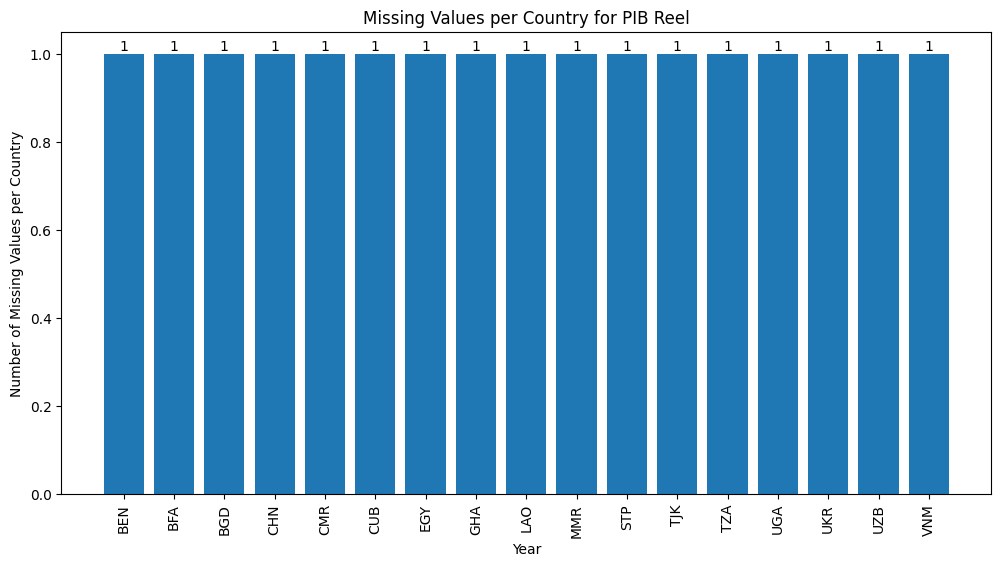

Index(['BEN', 'BFA', 'BGD', 'CHN', 'CMR', 'CUB', 'EGY', 'GHA', 'LAO', 'MMR',
       'STP', 'TJK', 'TZA', 'UGA', 'UKR', 'UZB', 'VNM'],
      dtype='object', name='country')

In [21]:
dv.plot_missing_values_per_country(responseTime_data,"avgResponseTime",treshold=0)

Certains des pays n'ont pas obtenu de temps de réponse avec notre algorithme. On pourrait modéliser en disant qu'ils ont un temps infiniment long ou juste prendre des valeurs arbitrairement grandes. Mais par souci de simplicité et de non penchant à faire des hypothèses fallacieuses, nous allons les sortir de la base de données et réalisés des études sur les pays qui ont un temps de réponse à des scénarios de crises.

In [22]:
responseTime_data.dropna(inplace=True)
responseTime_data.reset_index(drop=True,inplace=True)
responseTime_data

,country,avgResponseTime
0,AGO,7.000000
1,ALB,2.500000
2,AND,7.333333
3,ARE,2.666667
4,ARG,3.142857
...,...,...
157,VUT,4.500000
158,WSM,2.800000
159,ZAF,2.500000
160,ZMB,2.666667


# Importations et exportations

In [23]:
wb = dc.WorldBankData()

# Récupérer le PIB réel pour tous les pays du monde entre 1900 et 2024
liste_pays = codesISO_data["ISO-3"].tolist()
importations_data = wb.get_indicator("Importations", liste_pays, start=1990, end=2024)
exportations_data = wb.get_indicator("Exportations", liste_pays, start=1990, end=2024)

# Remplacer les noms des pays par leurs codes ISO dans les deux datasets
importations_data["country"] = importations_data['country'].apply(lambda x: matching_dictionnary[x] if x in matching_dictionnary.keys() else x)
exportations_data["country"] = exportations_data['country'].apply(lambda x: matching_dictionnary[x] if x in matching_dictionnary.keys() else x)

importations_data
exportations_data

,country,date,Exportations
0,AFG,2024,NaN
1,AFG,2023,16.852788
2,AFG,2022,18.380042
3,AFG,2021,14.342153
4,AFG,2020,10.420817
...,...,...,...
6750,ZWE,1994,34.601298
6751,ZWE,1993,30.720621
6752,ZWE,1992,27.227979
6753,ZWE,1991,23.883877


In [24]:
exportations_data

,country,date,Exportations
0,AFG,2024,NaN
1,AFG,2023,16.852788
2,AFG,2022,18.380042
3,AFG,2021,14.342153
4,AFG,2020,10.420817
...,...,...,...
6750,ZWE,1994,34.601298
6751,ZWE,1993,30.720621
6752,ZWE,1992,27.227979
6753,ZWE,1991,23.883877


In [25]:
da.check_missing_values(importations_data,"Importations")
da.check_missing_values(exportations_data,"Exportations")

Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 1232 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 18.24% de valeurs manquantes dans la base de données.
Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 1232 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 18.24% de valeurs manquantes dans la base de données.


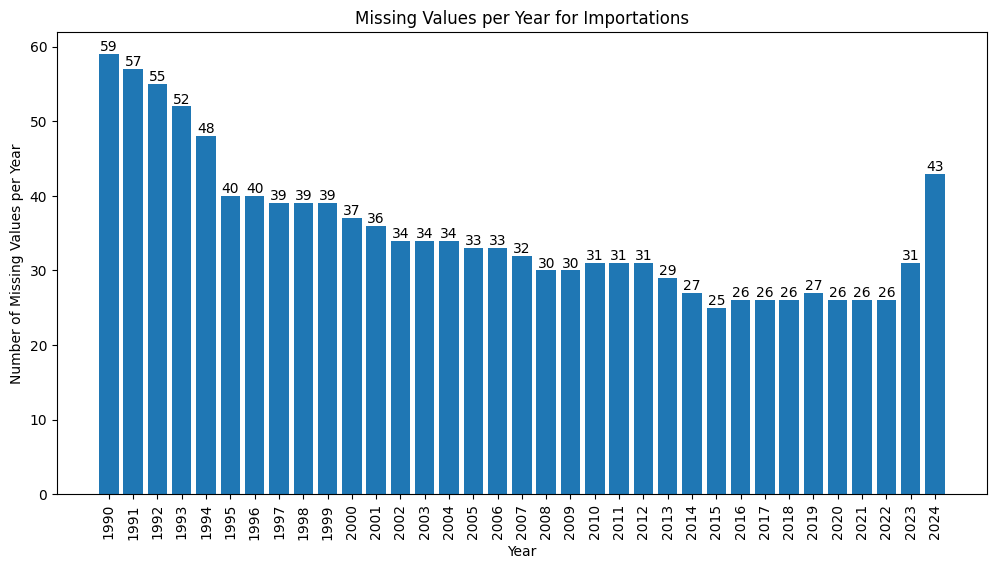

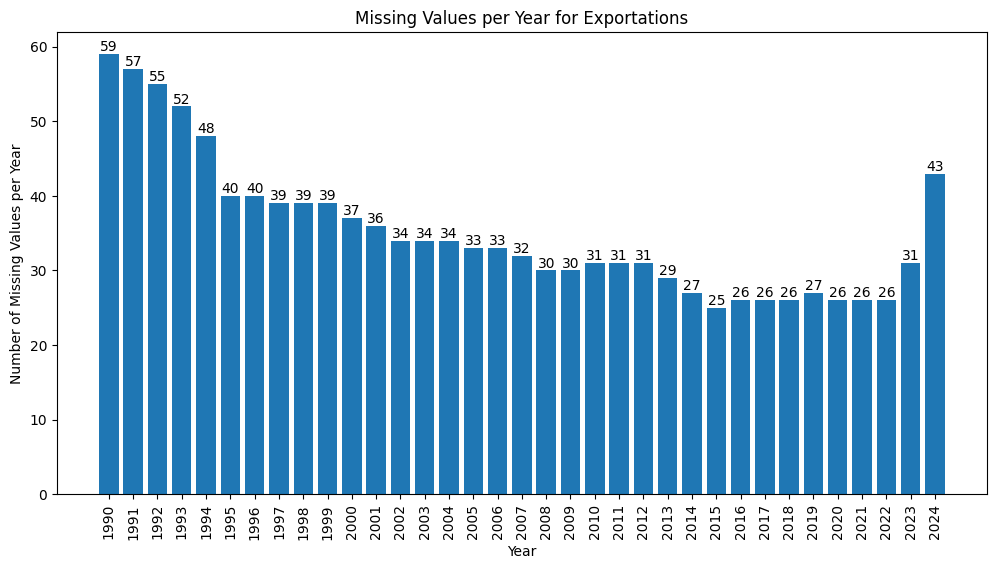

In [26]:
dv.plot_missing_values_per_year(importations_data,"Importations",text="Importations")
dv.plot_missing_values_per_year(exportations_data,"Exportations",text="Exportations")

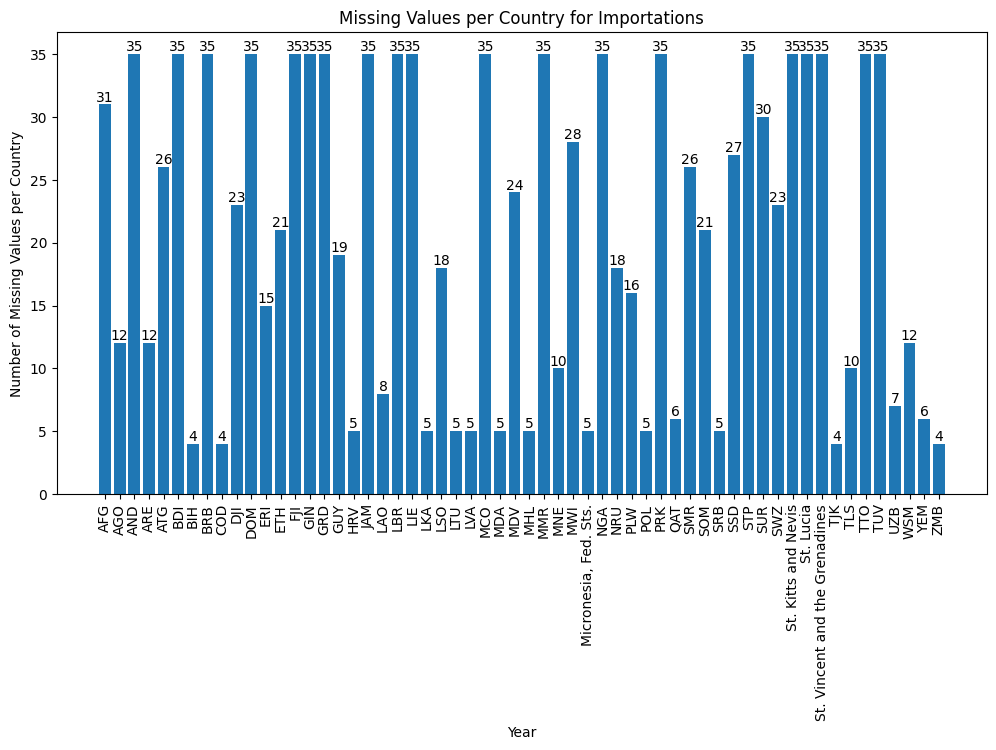

In [27]:
countries_toRemoveImportations = dv.plot_missing_values_per_country(importations_data,"Importations",treshold=0.1,text="Importations")

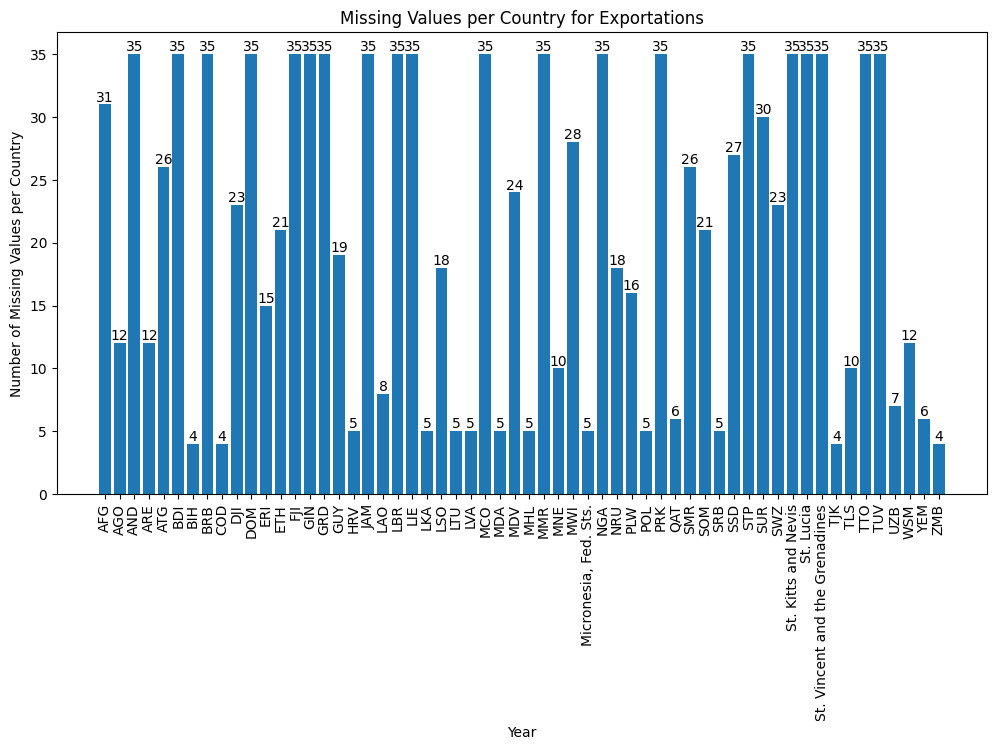

In [28]:
countries_toRemoveExportations = dv.plot_missing_values_per_country(exportations_data,"Exportations",treshold=0.1,text="Exportations")

In [29]:
indexes_toRemoveImports = []
indexes_toRemoveExports = []

for country in countries_toRemoveImportations:
    country_indexes = importations_data[importations_data["country"]==country].index.tolist()
    indexes_toRemove.extend(country_indexes)

for country in countries_toRemoveExportations:
    country_indexes = exportations_data[exportations_data["country"]==country].index.tolist()
    indexes_toRemoveExports.extend(country_indexes)

In [30]:
importations_data
da.check_missing_values(importations_data,"Importations")

importations_data = importations_data.drop(indexes_toRemove,axis='index')
importations_data.reset_index(drop=True,inplace=True)

da.check_missing_values(importations_data,"Importations")

Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 1232 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 18.24% de valeurs manquantes dans la base de données.
Le dataframe contient des données temporelles relatives à 131 pays de 1990 à 2024.
Il y a 22 valeurs manquantes sur un total de 4620 dans la base de données. Soit un ratio de 0.48% de valeurs manquantes dans la base de données.


In [31]:
exportations_data
da.check_missing_values(exportations_data,"Exportations")

exportations_data = exportations_data.drop(indexes_toRemove,axis='index')
exportations_data.reset_index(drop=True,inplace=True)

print("\n")
da.check_missing_values(exportations_data,"Exportations")

Le dataframe contient des données temporelles relatives à 189 pays de 1990 à 2024.
Il y a 1232 valeurs manquantes sur un total de 6755 dans la base de données. Soit un ratio de 18.24% de valeurs manquantes dans la base de données.


Le dataframe contient des données temporelles relatives à 131 pays de 1990 à 2024.
Il y a 22 valeurs manquantes sur un total de 4620 dans la base de données. Soit un ratio de 0.48% de valeurs manquantes dans la base de données.


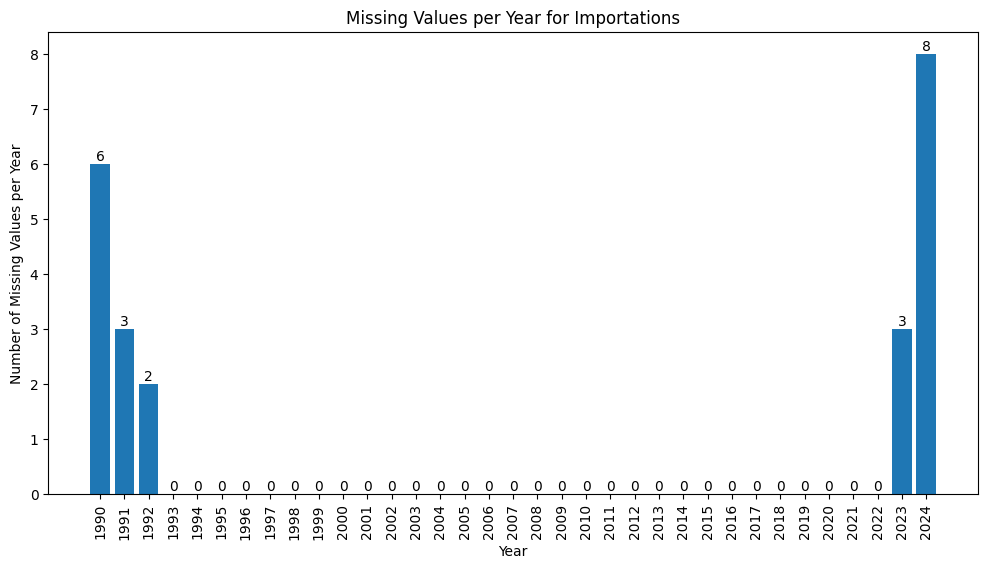

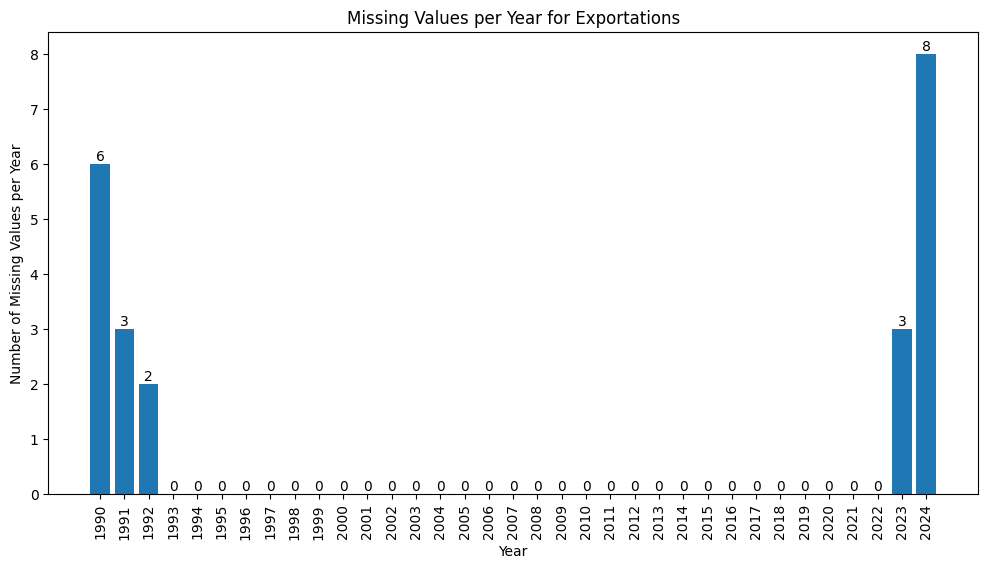

In [32]:
# On va voir où se situent les dernières valeurs manquantes
dv.plot_missing_values_per_year(importations_data,"Importations",text="Importations")
dv.plot_missing_values_per_year(exportations_data,"Exportations",text="Exportations")

In [33]:
# Des valeurs manquantes sont en 2023, 2024. On peut les imputer avec la moyenne des années précédentes.
# On impute en backward fill puis forward fill pour les cas où il y a des années consécutives manquantes

importations_data = da.impute_missing_values(importations_data,"Importations",method="backward_fill")
importations_data = da.impute_missing_values(importations_data,"Importations",method="forward_fill")
da.check_missing_values(importations_data,"Importations")

Le dataframe contient des données temporelles relatives à 131 pays de 1990 à 2024.
Il y a 0 valeurs manquantes sur un total de 4620 dans la base de données. Soit un ratio de 0.00% de valeurs manquantes dans la base de données.


In [34]:
# Des valeurs manquantes sont en 2023, 2024. On peut les imputer avec la moyenne des années précédentes.
# On impute en backward fill puis forward fill pour les cas où il y a des années consécutives manquantes

exportations_data = da.impute_missing_values(exportations_data,"Exportations",method="backward_fill")
exportations_data = da.impute_missing_values(exportations_data,"Exportations",method="forward_fill")
da.check_missing_values(exportations_data,"Exportations")

Le dataframe contient des données temporelles relatives à 131 pays de 1990 à 2024.
Il y a 0 valeurs manquantes sur un total de 4620 dans la base de données. Soit un ratio de 0.00% de valeurs manquantes dans la base de données.


In [35]:
# Fusion des deux datasets pour analyse conjointe
trade_data = pd.merge(importations_data,exportations_data,on=['country','date'])
trade_data

,country,date,Importations,Exportations
0,ALB,2024,43.169768,36.284869
1,ALB,2023,43.933672,38.418821
2,ALB,2022,47.500968,37.197076
3,ALB,2021,44.457348,31.133056
4,ALB,2020,36.979941,22.540759
...,...,...,...,...
4685,ZWE,1994,36.519563,34.601298
4686,ZWE,1993,32.448894,30.720621
4687,ZWE,1992,36.484086,27.227979
4688,ZWE,1991,27.168633,23.883877


In [36]:
trade_analyzer = da.TradeDataAnalyzer(trade_data=trade_data)
trade_analyzer.trade_data

,country,date,Importations,Exportations
0,ALB,2024,43.169768,36.284869
1,ALB,2023,43.933672,38.418821
2,ALB,2022,47.500968,37.197076
3,ALB,2021,44.457348,31.133056
4,ALB,2020,36.979941,22.540759
...,...,...,...,...
4685,ZWE,1994,36.519563,34.601298
4686,ZWE,1993,32.448894,30.720621
4687,ZWE,1992,36.484086,27.227979
4688,ZWE,1991,27.168633,23.883877


In [37]:
trade_analyzer.get_balance()
trade_analyzer.trade_data

,country,date,Importations,Exportations,commBalance
0,ALB,2024,43.169768,36.284869,-6.884899
1,ALB,2023,43.933672,38.418821,-5.514851
2,ALB,2022,47.500968,37.197076,-10.303892
3,ALB,2021,44.457348,31.133056,-13.324292
4,ALB,2020,36.979941,22.540759,-14.439182
...,...,...,...,...,...
4685,ZWE,1994,36.519563,34.601298,-1.918265
4686,ZWE,1993,32.448894,30.720621,-1.728273
4687,ZWE,1992,36.484086,27.227979,-9.256107
4688,ZWE,1991,27.168633,23.883877,-3.284756


# Classification en pays exportateurs nets

In [38]:
netExportators = trade_analyzer.classify_exporters(threshold=0)
netExportators

,country,netExportateur
0,ALB,0
1,ARG,1
2,ARM,0
3,AUS,0
4,AUT,1
...,...,...
126,VEN,1
127,VNM,0
128,VUT,0
129,ZAF,1


# Visualisation sur une carte

In [39]:
dv.visualize_trade_clusters(netExportators)

# Analyse des pays enclavés

In [40]:
try:
    landlocked_data = dc.get_rawlandlockedCountries(landlocked_url)
    landlocked_data = dcl.clean_landlockedData(landlocked_data)
except Exception as e:
    print(f"An error occurred while fetching or cleaning ISO codes data: {e}")
    landlocked_data = pd.read_csv("data/landlocked_data.csv")
    landlocked_data.drop(columns=['Unnamed: 0'], inplace=True)

landlocked_data

,country,Coastline
1,Canada,265523.0
2,Norway,53199.0
3,Indonesia,95181.0
4,European Union,NaN
5,Greenland,NaN
...,...,...
254,French Guiana,763.0
255,Guadeloupe,581.0
256,Martinique,369.0
257,Caribbean Netherlands,361.0


In [41]:
landlocked_data["country"] = landlocked_data['country'].apply(lambda x: matching_dictionnary[x] if x in matching_dictionnary.keys() else x)
landlocked_data

,country,Coastline
1,CAN,265523.0
2,NOR,53199.0
3,IDN,95181.0
4,European Union,NaN
5,Greenland,NaN
...,...,...
254,French Guiana,763.0
255,Guadeloupe,581.0
256,Martinique,369.0
257,Caribbean Netherlands,361.0


In [42]:
# Récupérer les pays avec des codes ISO à 3 lettres. Les pays qui n'ont pas de code ISO à 3 lettres ne sont pas reconnus par la World Bank donc on les enlève
validLandlockedData = landlocked_data[landlocked_data['country'].str.len() == 3].copy()
validLandlockedData

,country,Coastline
1,CAN,265523.0
2,NOR,53199.0
3,IDN,95181.0
7,PHL,33900.0
8,JPN,29020.0
...,...,...
248,TJK,0.0
249,UGA,0.0
250,UZB,1707.0
252,ZMB,0.0


In [43]:
# On va créer une colonne binaire pour indiquer si un pays est enclavé ou non
validLandlockedData['isLandlocked'] = (validLandlockedData['Coastline'] == 0).astype(int)
validLandlockedData.drop(columns=['Coastline'],inplace=True)
validLandlockedData

,country,isLandlocked
1,CAN,0
2,NOR,0
3,IDN,0
7,PHL,0
8,JPN,0
...,...,...
248,TJK,1
249,UGA,1
250,UZB,0
252,ZMB,1


In [44]:
dv.visualize_landlocked_countries(validLandlockedData)

## HDI Data

In [45]:
HDI_data = pd.read_excel("data/hdi-data.xlsx")
HDI_data

,countryIsoCode,country,indexCode,index,dimension,indicatorCode,indicator,year,value,note
0,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1990,0.285,NaN
1,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1991,0.291,NaN
2,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1992,0.301,NaN
3,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1993,0.311,NaN
4,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1994,0.305,NaN
...,...,...,...,...,...,...,...,...,...,...
6309,ZZK.WORLD,World,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2019,0.745,NaN
6310,ZZK.WORLD,World,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2020,0.742,NaN
6311,ZZK.WORLD,World,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2021,0.742,NaN
6312,ZZK.WORLD,World,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2022,0.752,NaN


In [46]:
hdiAnalyzer = da.HDIDataAnalyzer(HDI_data=HDI_data)
HDI_cleaned = hdiAnalyzer.clean_data()
HDI_cleaned

,country,date,HDI
0,AFG,1990,0.285
1,AFG,1991,0.291
2,AFG,1992,0.301
3,AFG,1993,0.311
4,AFG,1994,0.305
...,...,...,...
5935,ZWE,2019,0.584
5936,ZWE,2020,0.582
5937,ZWE,2021,0.581
5938,ZWE,2022,0.594


In [47]:
da.check_missing_values(HDI_cleaned,"HDI")

Le dataframe contient des données temporelles relatives à 193 pays de 1990 à 2023.
Il y a 0 valeurs manquantes sur un total de 5940 dans la base de données. Soit un ratio de 0.00% de valeurs manquantes dans la base de données.


### Faire un commentaire

In [48]:
aggregated_HDI = hdiAnalyzer.aggregated_HDI()
aggregated_HDI.sort_values(by="HDI_mean",ascending=False)

,country,HDI_mean
129,NOR,0.930912
82,ISL,0.922324
30,CHE,0.919324
44,DEU,0.916088
101,LIE,0.915958
...,...,...
158,SSD,0.372286
11,BDI,0.368294
114,MLI,0.357912
28,CAF,0.346625


In [49]:
dv.visualize_HDI_clusters(aggregated_HDI)

# Fusion des bases

In [50]:
merged_data = (
    aggregated_HDI
    .merge(responseTime_data, on=["country"], how="outer")
    .merge(validLandlockedData, on=["country"], how="outer")
    .merge(netExportators, on=["country"], how="outer")
    .merge(weightCountry, on=["country"], how="outer")
)

merged_data.sort_values(by="country",ascending=True)

,country,HDI_mean,avgResponseTime,isLandlocked,netExportateur,avgWeightCountry
0,AFG,0.415853,NaN,1.0,NaN,NaN
1,AGO,0.527600,7.000000,0.0,NaN,0.102863
2,ALB,0.727824,2.500000,0.0,0.0,0.014401
3,AND,0.862833,7.333333,0.0,NaN,0.004426
4,ARE,0.820941,2.666667,0.0,NaN,0.444654
...,...,...,...,...,...,...
201,WSM,0.694655,2.800000,0.0,NaN,0.001154
202,YEM,0.450853,NaN,NaN,NaN,NaN
203,ZAF,0.667618,2.500000,0.0,1.0,0.467429
204,ZMB,0.495559,2.666667,1.0,NaN,0.022953


In [51]:
merged_data.dropna(inplace=True)
merged_data

,country,HDI_mean,avgResponseTime,isLandlocked,netExportateur,avgWeightCountry
2,ALB,0.727824,2.500000,0.0,0.0,0.014401
5,ARG,0.813059,3.142857,0.0,1.0,0.795024
6,ARM,0.716588,4.000000,1.0,0.0,0.012419
8,AUS,0.914588,2.000000,0.0,0.0,1.814523
9,AUT,0.893706,2.666667,1.0,1.0,0.583434
...,...,...,...,...,...,...
195,USA,0.909147,2.000000,0.0,0.0,26.250237
198,VEN,0.721382,3.000000,0.0,1.0,0.167288
200,VUT,0.595632,4.500000,0.0,0.0,0.001051
203,ZAF,0.667618,2.500000,0.0,1.0,0.467429


# Implémentation de la régression

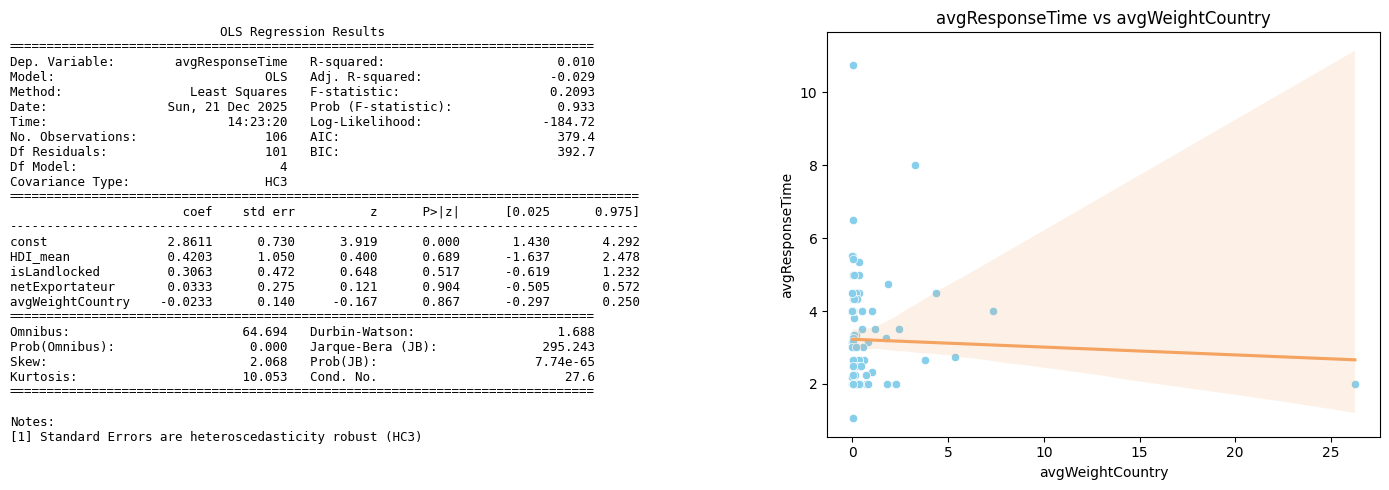

In [52]:
rg.perform_regression(merged_data, ['HDI_mean', 'isLandlocked', 'netExportateur', 'avgWeightCountry'],'avgResponseTime', method='HC3')

# Régressions séparées

In [53]:
highPowerCountries = clusters_EconomicPower[(clusters_EconomicPower["Power"] == 2) | (clusters_EconomicPower["Power"] == 3) | (clusters_EconomicPower["Power"] == 1)]["country"].tolist()
highPowerCountries

dummy = merged_data[merged_data["avgWeightCountry"] > 1]["country"].tolist()

In [54]:
lowPowerCountries = clusters_EconomicPower[(clusters_EconomicPower["Power"] == 0)].sort_values(by="avgWeightCountry",ascending=False)["country"].tolist()

In [55]:
dataHighPower = merged_data[merged_data["country"].isin(highPowerCountries+lowPowerCountries[:10])]
dataLowPower = merged_data[merged_data["country"].isin(lowPowerCountries[10:])]

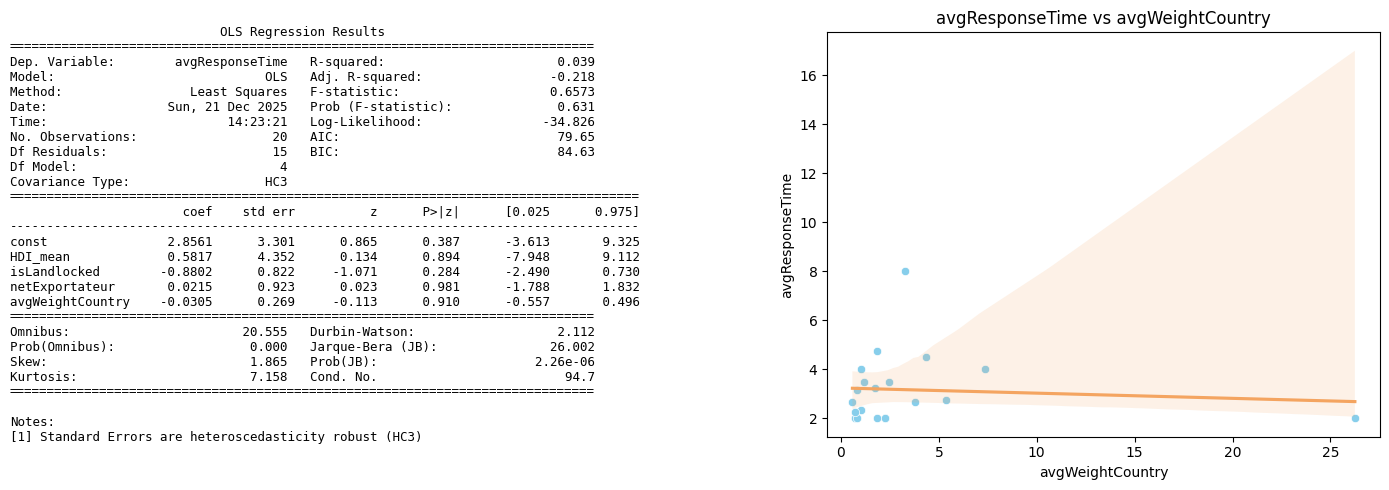

In [56]:
rg.perform_regression(dataHighPower, ['HDI_mean', 'isLandlocked', 'netExportateur', 'avgWeightCountry'],'avgResponseTime', method='HC3')

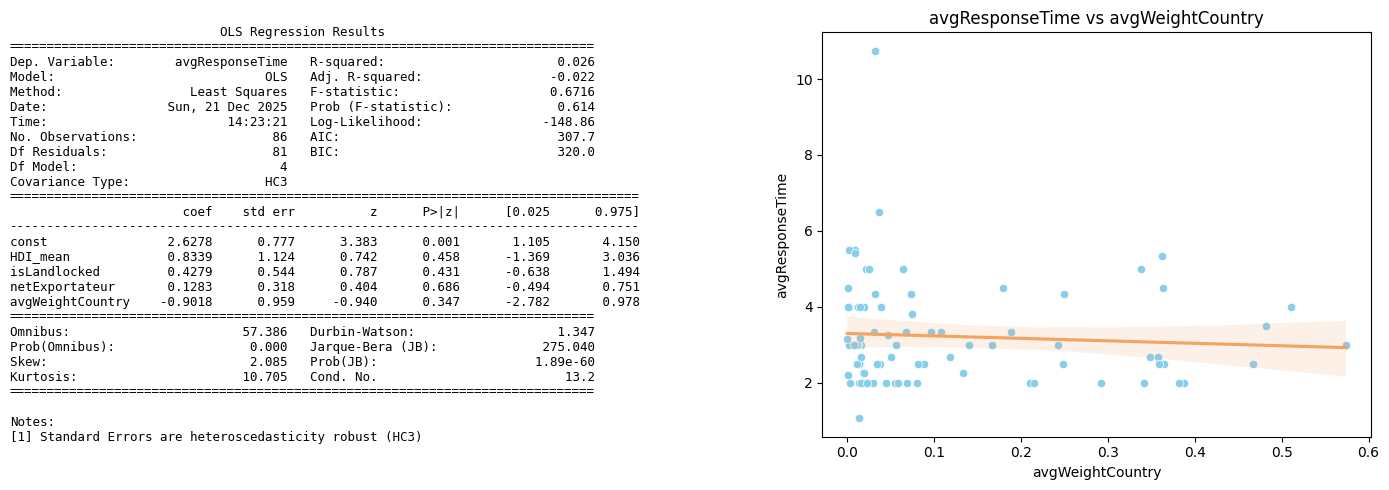

In [57]:
rg.perform_regression(dataLowPower, ['HDI_mean', 'isLandlocked', 'netExportateur', 'avgWeightCountry'],'avgResponseTime', method='HC3')

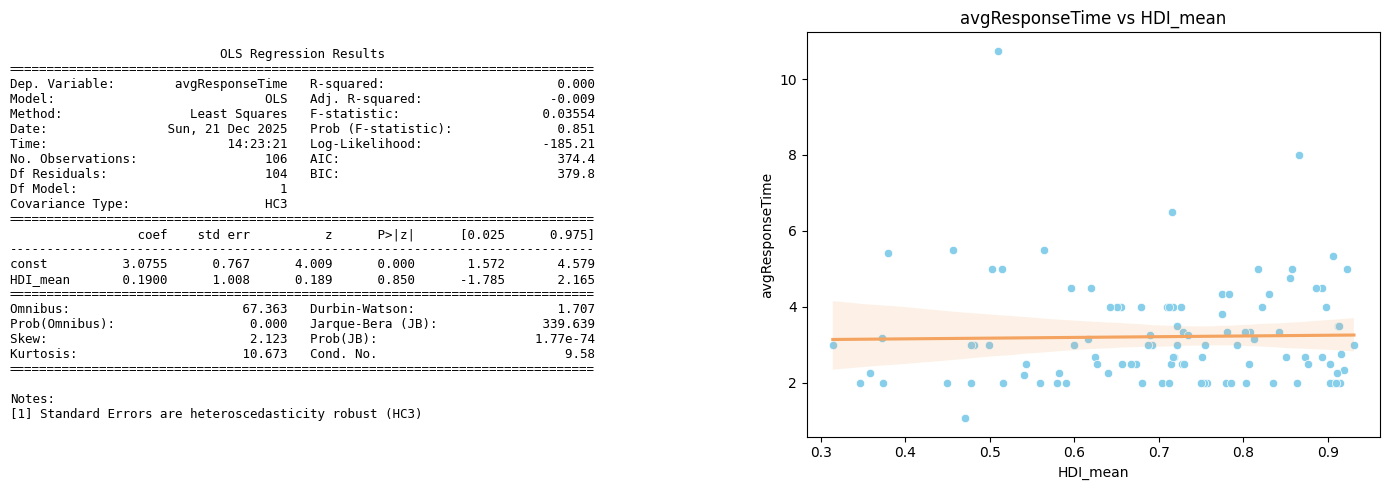

In [58]:
rg.perform_regression(merged_data, ['HDI_mean'],'avgResponseTime', method='HC3',plotnum=0)